# 计算机视觉中的样式迁移（风格迁移）

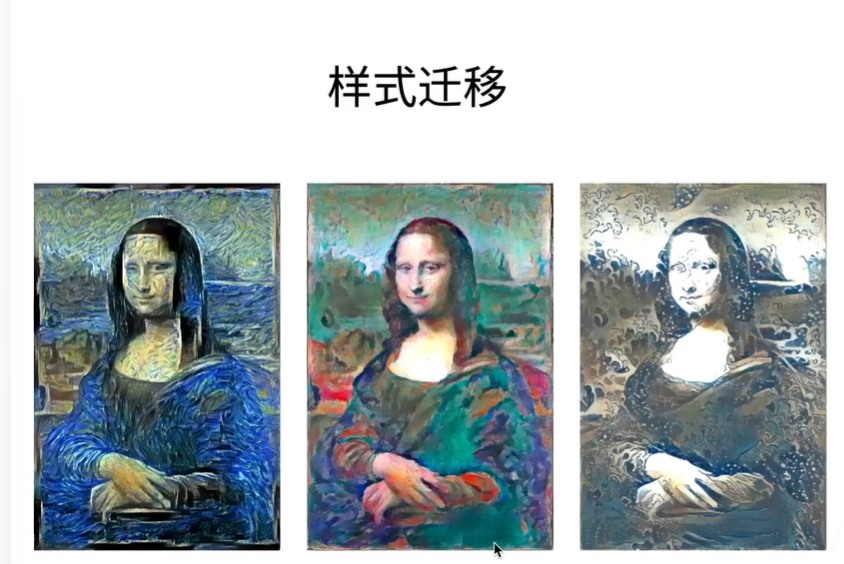

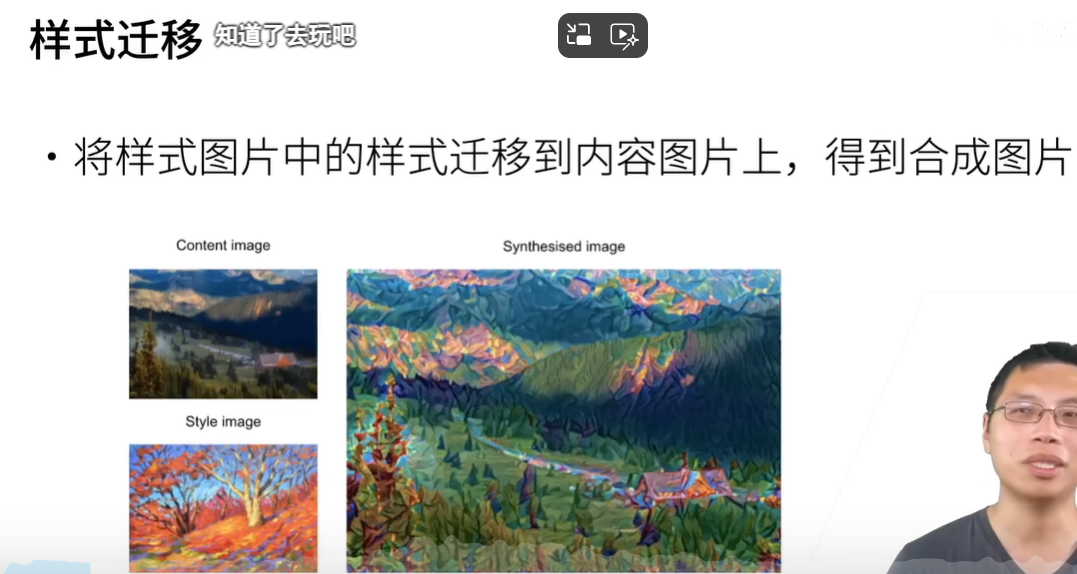

本节将介绍如何使用卷积神经网络，自动将一个图像中的风格应用在另一图像之上，即风格迁移（style transfer） (Gatys et al., 2016)。 这里我们需要两张输入图像：一张是内容图像，另一张是风格图像。 我们将使用神经网络修改内容图像，使其在风格上接近风格图像。 例如， 图13.12.1中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园拍摄的风景照，而风格图像则是一幅主题为秋天橡树的油画。 最终输出的合成图像应用了风格图像的油画笔触让整体颜色更加鲜艳，同时保留了内容图像中物体主体的形状。

# 得到合成的图片（滤镜）

# 基于CNN的样式迁移

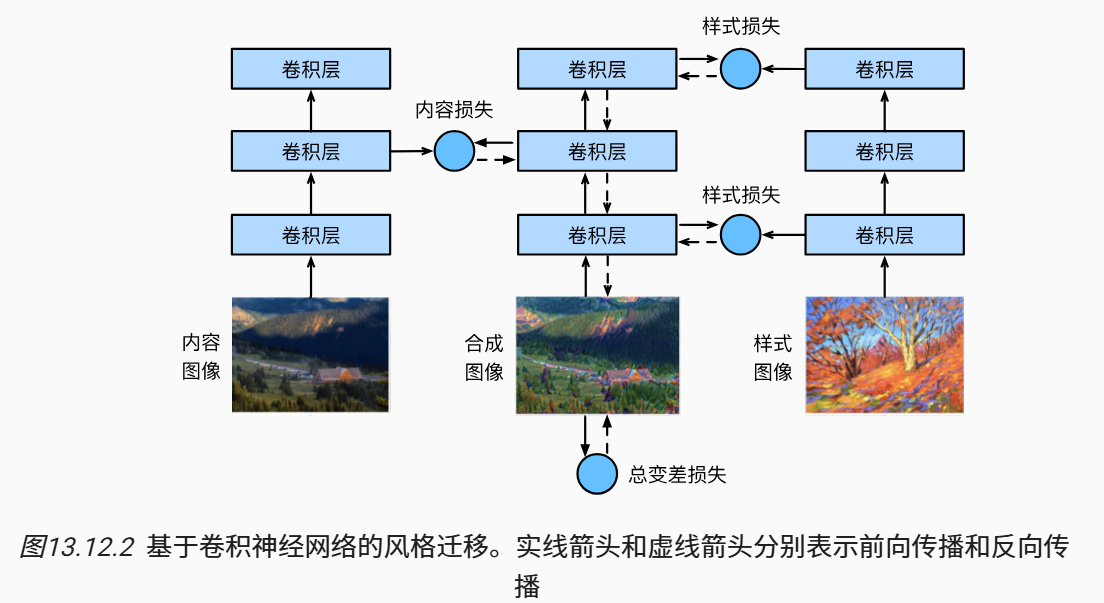

理解
训练的核心思想：
第一步：算出原图片和风格图片经过某一层神经网络处理后的值（神经网络相同，但是原图片和风格图片选择的层不同，下面将所选择的层分别称为原图片层和风格层）
第二步：将原图片再作为输入，分别得到其经过原图片层，风格层获得的输出
第三步：将这些输出与第一步中所得到的值计算损失，并更新输出图片参数
第四步：将输出图片作为输入，重复第二、三步
这样最后的输出图片变为在原图片层的输出与原图相似，在风格层的输出与风格图相似，即达到了样式迁移效果。

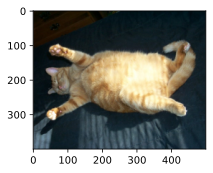

In [33]:
# 样式迁移的实现
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('cat1.jpg')
d2l.plt.imshow(content_img);

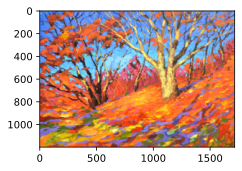

In [34]:
style_img = d2l.Image.open('autumn_oak.jpg')
d2l.plt.imshow(style_img);

In [35]:
# 定义图像的预处理函数和后处理函数。 
# 预处理函数preprocess对输入图像在RGB三个通道分别做标准化，
# 并将结果变换成卷积神经网络接受的输入格式。 
# 后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。
# 由于图像打印函数要求每个像素的浮点数值在0～1之间，我们对小于0和大于1的值分别取0和1。


# 定义 RGB 通道的均值和标准差，用于图像归一化
rgb_mean = torch.tensor([0.485, 0.456, 0.406])  # 预处理时使用的均值
rgb_std = torch.tensor([0.229, 0.224, 0.225])    # 预处理时使用的标准差

# 定义预处理函数
def preprocess(img, image_shape):
    # 创建一个由多个变换组成的流水线
    transforms = torchvision.transforms.Compose([
        # 将图像调整为指定的形状
        torchvision.transforms.Resize(image_shape),
        # 将图像转换为张量，范围从0-255转换为0-1
        torchvision.transforms.ToTensor(),
        # 使用均值和标准差对张量进行标准化
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    
    # 返回经过变换后的图像，并增加一个维度以符合 batch size 的要求
    return transforms(img).unsqueeze(0)  # unsqueeze(0) 在第0维增加一个维度，表示 batch_size 为 1

# 定义后处理函数
def postprocess(img):
    # 将输入图像的第一个样本（如果是batch的形式）
    img = img[0].to(rgb_std.device)  # 将张量移到与标准差相同的设备上
    
    # 对图像进行反标准化，恢复到原来的范围
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    # permute(1, 2, 0)将通道维移动到最后一维，以符合 PIL 图像格式
    
    # 将张量转换为 PIL 图像
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))  # 再次调整维度顺序，以符合 PIL 图像要求

In [36]:
# 加载了一个预训练的 VGG19 网络
pretrained_net = torchvision.models.vgg19(pretrained=True)

D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# 分别用于存储在风格迁移（Style Transfer）过程中选择的特征层的索引
style_layers = [0, 5, 10, 19, 28]
content_layers = [25]

# 0: conv1_1（第一层卷积）
# 5: conv2_2（第二个卷积层）
# 10: conv3_3（第三个卷积层）
# 19: conv4_3（第四个卷积层）
# 28: conv5_3（第五个卷积层）
    
# 25 通常对应于 VGG19 中的 conv4_2 层，该层对图像的整体内容有较强的表征能力。
# 使用这一层的特征可以有效地捕捉到图像的主要结构与信息。

In [38]:
# 构建了一个新的神经网络 net，
# 它是通过从一个预训练的网络（pretrained_net）中提取特定层来创建的



net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [39]:
def extract_features(X, content_layers, style_layers):
    # 用于存储提取的内容特征和风格特征
    contents = []
    styles = []
    
    # 遍历预训练网络中的每一层
    for i in range(len(net)):
        # 通过当前层处理输入 X
        X = net[i](X) 
        
        # 如果当前层是风格层，将特征添加到 styles 列表
        if i in style_layers:
            styles.append(X)
        
        # 如果当前层是内容层，将特征添加到 contents 列表
        if i in content_layers:
            contents.append(X)
    
    # 返回提取的内容特征和风格特征
    return contents, styles

In [40]:
def get_contents(image_shape, device):
    # 预处理内容图像并将其转移到指定的设备上（如 GPU）
    content_X = preprocess(content_img, image_shape).to(device)
    
    # 提取内容特征
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    
    # 返回预处理后的内容图像和提取的内容特征
    return content_X, contents_Y


def get_styles(image_shape, device):
    # 预处理风格图像并将其转移到指定的设备上（如 GPU）
    style_X = preprocess(style_img, image_shape).to(device)
    
    # 提取风格特征
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    
    # 返回预处理后的风格图像和提取的风格特征
    return style_X, styles_Y

In [41]:
# 计算内容损失
# 通过平方误差函数衡量合成图像与内容图像在内容特征上的差异
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [42]:
# 风格损失与内容损失类似，也通过平方误差函数衡量合成图像与风格图像在风格上的差异

# n 是 样本数*宽*高，相当于所有图片的“每个像素作为统计意义上的样本”
# 通道之间的统计分布基本上能匹配上 就两个图片相似（也就是通道通道之间的关系相近）
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [43]:
# 风格损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与风格图像的风格层输出。这里假设基于风格图像的格拉姆矩阵gram_Y已经预先计算好了
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

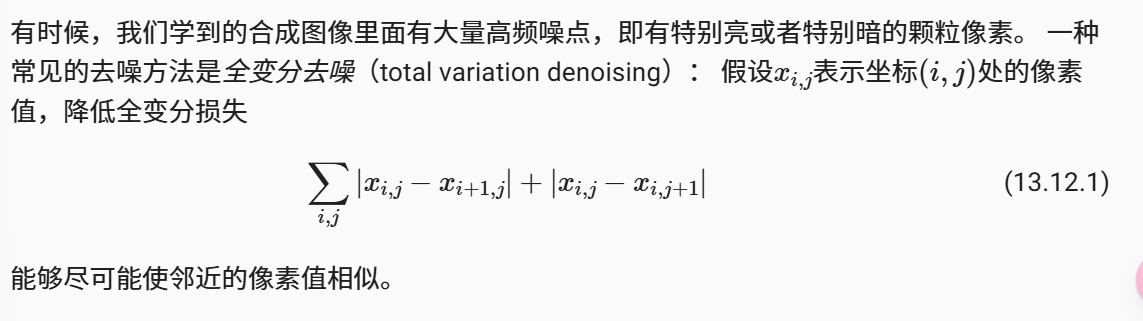

In [44]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [45]:
# 风格转移的损失函数是内容损失、风格损失和总变化损失的加权和。 
# 通过调节这些权重超参数，
# 我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性
# 定义权重参数

# 定义了一个函数 compute_loss，用于计算在风格迁移中各个部分的损失，
# 包括内容损失、风格损失和全变分损失 (Total Variation Loss)
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    
    # 计算内容损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    
    # 计算风格损失
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    
    # 计算全变分损失
    tv_l = tv_loss(X) * tv_weight
    
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    
    return contents_l, styles_l, tv_l, l

In [46]:
# 在风格迁移中，合成的图像是训练期间唯一需要更新的变量

# 模型的前向传播只需返回模型参数即可


class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [47]:
def get_inits(X, device, lr, styles_Y):
    # 初始化生成的图像，使用 SynthesizedImage 类实例化
    gen_img = SynthesizedImage(X.shape).to(device)
    
    # 将输入图像 X 的权重复制给生成的图像
    gen_img.weight.data.copy_(X.data)
    
    # 创建 Adam 优化器，设置学习率
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    
    # 计算风格的 Gram 矩阵
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    
    # 返回生成的图像、风格的 Gram 矩阵和优化器
    return gen_img(), styles_Y_gram, trainer

In [48]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    # 初始化生成图像、风格 Gram 矩阵和优化器
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    
    # 设置学习率调度器，每经过 lr_decay_epoch 次迭代将学习率减少到原来的 80%
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    
    # 创建一个动图对象，用于可视化训练过程中的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    # 进行多轮训练
    for epoch in range(num_epochs):
        # 将梯度置零
        trainer.zero_grad()
        
        # 提取内容和风格特征
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        
        # 计算损失
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        # 反向传播计算梯度
        l.backward()
        
        # 更新生成图像的参数
        trainer.step()
        
        # 更新学习率
        scheduler.step()
        
        # 每10个epoch可视化一次生成图像和损失
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))  # 可视化生成的图像
            animator.add(epoch + 1, [float(sum(contents_l)), 
                                     float(sum(styles_l)), 
                                     float(tv_l)])  # 添加当前 epoch 的损失数据
    
    return X  # 返回训练好的生成图像

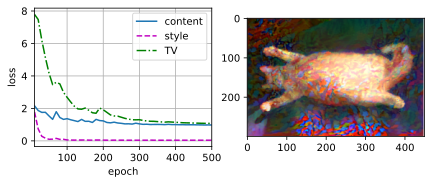

In [49]:
# 获取可用的 GPU 设备，如果没有，则使用 CPU
device, image_shape = d2l.try_gpu(), (300, 450)
# 定义图像的目标尺寸，这里设为 300 像素的高度和 450 像素的宽度。

# 将网络模型移动到指定的设备（GPU 或 CPU）
net = net.to(device)

# 获取内容图像及其提取的特征
content_X, contents_Y = get_contents(image_shape, device)

# 获取风格图像及其提取的特征
_, styles_Y = get_styles(image_shape, device)

# 开始训练，进行风格迁移

# content_X: 输入的内容图像。
# contents_Y: 从内容图像中提取的内容特征。
# styles_Y: 从风格图像中提取的风格特征。
# device: 配置的设备（GPU 或 CPU）。
# 0.3: 学习率，控制参数更新的步伐。
# 500: 训练的轮数（epochs）。
# 50: 学习率衰减的周期

output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

特征提取：

使用预训练的卷积神经网络（如 VGG19）来提取内容图像和风格图像的特征。网络的不同层会捕捉到不同层次的信息：
内容特征：通常从较深的网络层提取，体现了图像的结构和语义信息。
风格特征：从较浅的网络层提取，通常会计算特征图的 Gram 矩阵来表示风格

损失计算：

内容损失：计算生成图像与内容图像在内容特征空间中的差异，通常使用均方误差来衡量。
风格损失：计算生成图像与风格图像在风格特征空间中的差异，依赖于 Gram 矩阵的相似度。
总变分损失（可选）：用于平滑生成图像，减少噪声。
图像生成：

通过优化算法（如 Adam）迭代更新生成图像的像素，使得损失最小化，从而最终生成结合了内容和风格的新图像。